## Predicting Teens' Usage of Contraception using Mixed Linear Effects Models in R.

These data come from a study that examined the effect of a behavioral intervention on teens’ use of contraception. A description of the study and a link to the data can be found here: http://www.statsci.org/data/general/protsex.html

In [2]:
# Load & Explore data

datateens <- read.table("http://www.statsci.org/data/general/protsex.txt", header = TRUE)
head(datateens)
str(datateens)

BST,Pre,Post,FU6,FU12
1,7,22,13,14
1,25,10,17,24
1,50,36,49,23
1,16,38,34,24
1,33,25,24,25
1,10,7,23,26


'data.frame':	20 obs. of  5 variables:
 $ BST : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Pre : int  7 25 50 16 33 10 13 22 4 17 ...
 $ Post: int  22 10 36 38 25 7 33 20 0 16 ...
 $ FU6 : int  13 17 49 34 24 23 27 21 12 20 ...
 $ FU12: int  14 24 23 24 25 26 24 11 0 10 ...


There are 10 participants for each of the two conditions. Observations for for 4 timepoints. 
BST is a between-subjects variable with two levels. Time is a within-subjects variable with four levels (the values are the log-frequency of protected sex). 

variable description for dataset
* Variable		Description
* BST		1 = BST intervention, 0 = control
* Pre		Log-frequency of protected sex before the intervention
* Post	  Log-frequency of protected sex after the intervention
* FU6		Log-frequency of protected sex reported at the 6 months follow-up
* FU12		Log-frequency of protected sex reported at the 12 months follow-up


In [3]:
# Remove the column corresponding to the 12-month follow-up (we only want 3 time points).
datateens$FU12 <- NULL 

In [4]:
# Create a long-form dataset. you can do this using the reshape() function.
install.packages("reshape")
library(reshape)
datateens.long <- reshape(datateens, idvar = "subject", direction = "long", times = c("Pre", "Post", "FU6"), v.names = "frequency", varying = c("Pre", "Post", "FU6"))
datateens.long$time <- factor(datateens.long$time, levels = c("Pre", "Post", "FU6")) 
datateens.long$subject <- factor(datateens.long$subject)
str(datateens.long)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


'data.frame':	60 obs. of  4 variables:
 $ BST      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ time     : Factor w/ 3 levels "Pre","Post","FU6": 1 1 1 1 1 1 1 1 1 1 ...
 $ frequency: int  7 25 50 16 33 10 13 22 4 17 ...
 $ subject  : Factor w/ 20 levels "1","2","3","4",..: 1 2 3 4 5 6 7 8 9 10 ...
 - attr(*, "reshapeLong")=List of 4
  ..$ varying:List of 1
  .. ..$ frequency: chr  "Pre" "Post" "FU6"
  .. ..- attr(*, "v.names")= chr "frequency"
  .. ..- attr(*, "times")= chr  "Pre" "Post" "FU6"
  ..$ v.names: chr "frequency"
  ..$ idvar  : chr "subject"
  ..$ timevar: chr "time"


In [5]:
cellmeans <- tapply(datateens.long$frequency, list(datateens.long$BST, datateens.long$time), mean) 
cellmeans

,Pre,Post,FU6
0,29.5,18.8,7.5
1,19.7,20.7,24.0


In [6]:
head(datateens.long)

,BST,time,frequency,subject
1.Pre,1,Pre,7,1
2.Pre,1,Pre,25,2
3.Pre,1,Pre,50,3
4.Pre,1,Pre,16,4
5.Pre,1,Pre,33,5
6.Pre,1,Pre,10,6


In [7]:
install.packages('ggplot2')
library(ggplot2)
install.packages('plyr')
library(plyr)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done

Attaching package: ‘plyr’

The following objects are masked from ‘package:reshape’:

    rename, round_any



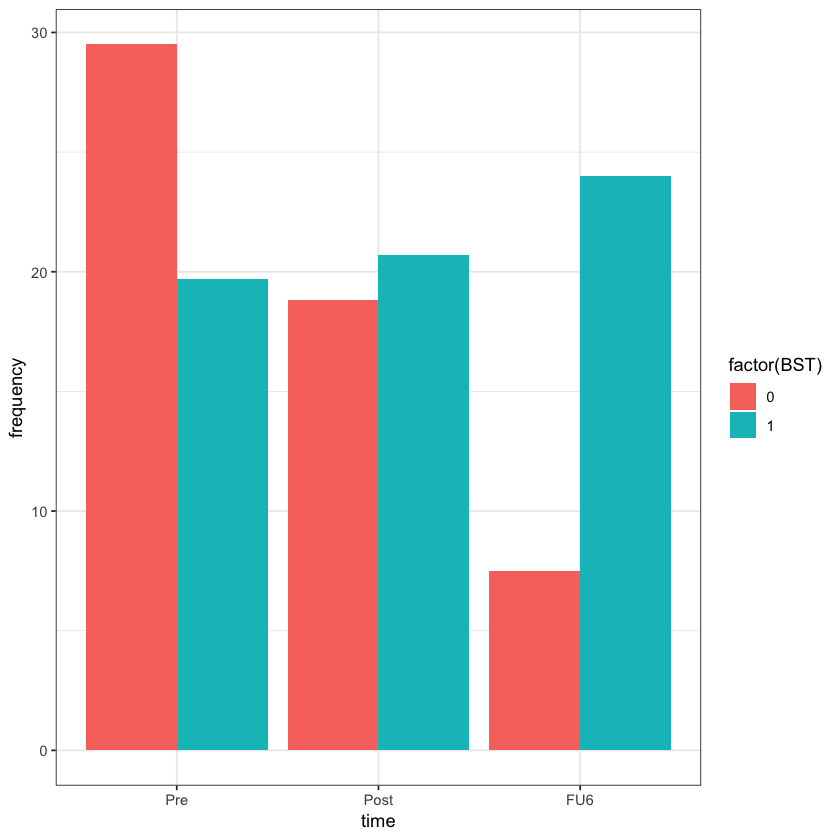

In [8]:
means <- aggregate(frequency ~ BST + time , datateens.long, mean)

ggplot(means, aes(x = time, y = frequency, fill = factor(BST))) + 
    geom_bar(stat = "identity", position = "dodge") +
    theme_bw()

In [9]:
Int <- ddply(datateens.long,.(time,BST),summarise, val = mean(frequency))

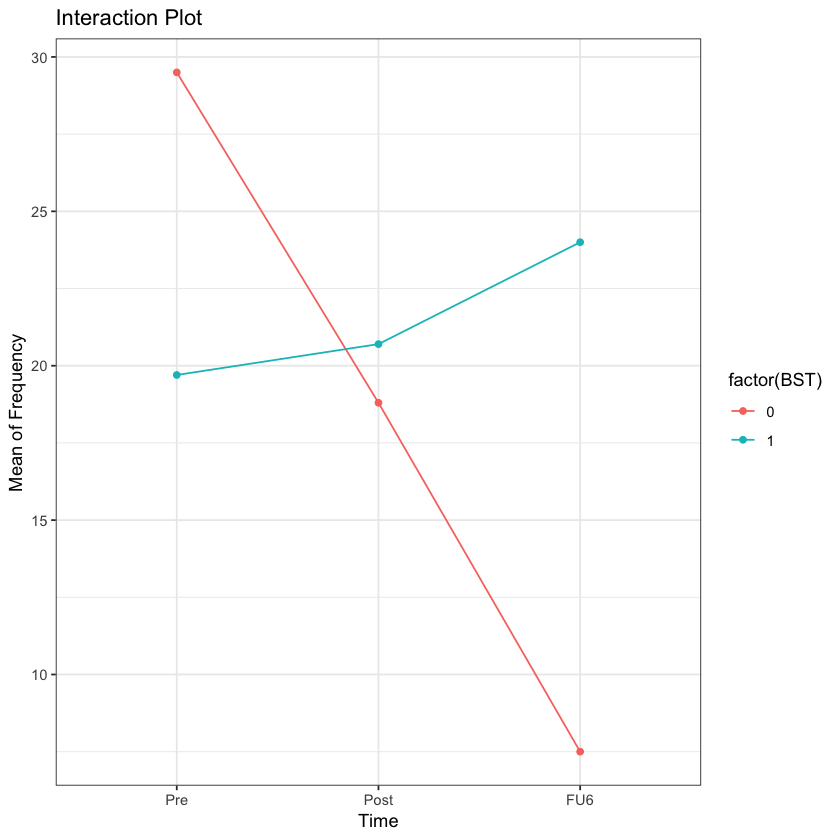

In [10]:
ggplot(datateens.long, aes(x=factor(time), y = mean(frequency), colour = factor(BST))) +
    geom_point(data = Int, aes(y = val)) +
    geom_line(data = Int, aes(y = val, group = BST)) +
    theme_bw() +
    labs(title = "Interaction Plot", x = "Time", y='Mean of Frequency')

#### So what does this tell us so far? 
Based on the figure I certainly would expect a significant interaction, simply because the lines cross. I would probably also
expect the main effect of time to be significant, but since there is an interaction this main effect shouldn't be interpreted.
The variable which has the main effect (in this case: time) should always be qualified in terms of the impact of the second variable (in this case,  *BST*).

# Linear mixed effects models. 

So what's next. We can jump straight to fitting a linear mixed effects model with a random intercept and slope, but first things first. 

Let's have a look at the fit of a linear mixed effect model, with a **random intercept for each subject**.


In [21]:
install.packages('nlme')
library(nlme)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [22]:
fit <- lme(frequency ~ time * BST, random = ~ 1 | subject, data=datateens.long)
summary(fit)

Linear mixed-effects model fit by REML
 Data: datateens.long 
       AIC      BIC    logLik
  476.4088 492.3207 -230.2044

Random effects:
 Formula: ~1 | subject
        (Intercept) Residual
StdDev:    12.46897 11.84872

Fixed effects: frequency ~ time * BST 
             Value Std.Error DF   t-value p-value
(Intercept)   29.5  5.439369 36  5.423423  0.0000
timePost     -10.7  5.298911 36 -2.019283  0.0510
timeFU6      -22.0  5.298911 36 -4.151797  0.0002
BST           -9.8  7.692430 18 -1.273980  0.2189
timePost:BST  11.7  7.493791 36  1.561292  0.1272
timeFU6:BST   26.3  7.493791 36  3.509572  0.0012
 Correlation: 
             (Intr) timPst timFU6 BST    tP:BST
timePost     -0.487                            
timeFU6      -0.487  0.500                     
BST          -0.707  0.344  0.344              
timePost:BST  0.344 -0.707 -0.354 -0.487       
timeFU6:BST   0.344 -0.354 -0.707 -0.487  0.500

Standardized Within-Group Residuals:
        Min          Q1         Med          Q3  

In [47]:
coef(fit)

(Intercept),timePost,timeFU6,BST,timePost:BST,timeFU6:BST
23.76081,-10.7,-22,-9.8,11.7,26.3
26.32295,-10.7,-22,-9.8,11.7,26.3
47.58870,-10.7,-22,-9.8,11.7,26.3
35.54665,-10.7,-22,-9.8,11.7,26.3
34.00936,-10.7,-22,-9.8,11.7,26.3
23.24838,-10.7,-22,-9.8,11.7,26.3
31.70344,-10.7,-22,-9.8,11.7,26.3
29.14130,-10.7,-22,-9.8,11.7,26.3
17.09925,-10.7,-22,-9.8,11.7,26.3
26.57916,-10.7,-22,-9.8,11.7,26.3


## Interpretation of model fit

As you can see above, each participant is assigned a different intercept (what you would expect, since we've told the model with `1|subject` to take by-subject variability into account. 

Let's interpret the significant fixed effects results from the analysis above:

* The estimate of protected sex frequency for `timePre` is 29.5, so the **average** protected sex frequency for all participants at `timePre` is 29.5 -- *If all other variables remain constant*.

* The estimate of protected sex frequency for `timeFU6` is 29.5 - 22, so the average sex frequency for all participants at `timeFU6` is 22 units lower compared to the reference category (`timePre`) -- *If all other variables remain constant*. But we also have a significant interaction for `BST` and `timeFU6`, which means we need to interpret the interaction, and not this main effect (since it is moderated by `BST`). 

* The significant interaction tells us that the amount of protected sex at `timeFU6` was significantly different for participants who where either in controlgroup (`BST=0`) or received intervention (`BST=1`). The interaction value is for participants who received intervention (`BST=1`), and therefore the estimate for the interaction between `TimeFU6` and `BST=1` is 29.5 + 26.3, which means that participants who received intervention had an increase of protected sex by 26.3 units. 

As example, the predicted value for subject 1 at time = Pre and BST = 0 is: 

In [27]:
intercept <- fit$coefficients$fixed[1]
coef <- fit$coefficients$random$subject[1]

predicted <- intercept + coef
predicted

(Intercept) 
   23.76081

23.7608083 is the predicted value for subject 1 at `timePre` and `BST=0`

## Linear mixed effects models II

Next is to fit a random intercept model with a **random slope for each subject and time.**

In [48]:
fit2 <- lme(frequency ~ time * BST, random = ~ time | subject, data=datateens.long)
summary(fit2)

Linear mixed-effects model fit by REML
 Data: datateens.long 
       AIC      BIC    logLik
  473.3924 499.2492 -223.6962

Random effects:
 Formula: ~time | subject
 Structure: General positive-definite, Log-Cholesky parametrization
            StdDev    Corr         
(Intercept) 19.328025 (Intr) timPst
timePost    12.484886 -0.420       
timeFU6     14.410090 -0.903  0.284
Residual     6.019397              

Fixed effects: frequency ~ time * BST 
             Value Std.Error DF   t-value p-value
(Intercept)   29.5  6.401607 36  4.608218  0.0000
timePost     -10.7  4.778480 36 -2.239206  0.0314
timeFU6      -22.0  5.292608 36 -4.156741  0.0002
BST           -9.8  9.053239 18 -1.082486  0.2933
timePost:BST  11.7  6.757791 36  1.731335  0.0920
timeFU6:BST   26.3  7.484878 36  3.513751  0.0012
 Correlation: 
             (Intr) timPst timFU6 BST    tP:BST
timePost     -0.449                            
timeFU6      -0.849  0.345                     
BST          -0.707  0.318  0.600     

In [30]:
coef(fit2)

(Intercept),timePost,timeFU6,BST,timePost:BST,timeFU6:BST
18.170420,0.1515466,-18.536433,-9.8,11.7,26.3
31.014161,-19.8668247,-26.178577,-9.8,11.7,26.3
58.913586,-24.2230945,-33.744896,-9.8,11.7,26.3
30.609470,1.2761249,-18.752046,-9.8,11.7,26.3
40.375928,-16.2745622,-30.920797,-9.8,11.7,26.3
19.934741,-13.4283232,-14.145183,-9.8,11.7,26.3
26.509775,1.1212663,-18.734695,-9.8,11.7,26.3
30.714855,-12.0821300,-24.444013,-9.8,11.7,26.3
12.619132,-12.2927104,-13.463721,-9.8,11.7,26.3
26.137932,-11.3812928,-21.079640,-9.8,11.7,26.3


Spot the difference? Now we've fitted a random intercept and random slope model. Each participant is assigned a different intercept and different values for each timepoint. This is because we've told the model with `time | subject` to take by-subject and by-time variability into account. 

## Interpretation of model fit2

As you can see, the fixed effects of the second model are not different than the fixed effects from the first model. So let's have a look at the random effects part then. 

The standard deviation is a measure of the variability for each random effect that we've added to the model, whilst the residual is the variability that's not due to either of the random effects we've added (so basically, that is your error term). 

But now comes the question: We've calculated two models.
* one with a random intercept for each subject
* one with a random intercept for each subject and a random slope for time. 

Which model do we choose - or think is *best* so to say? 

# Model selection

Usually, when adding more parameters to a model (e.g. the model becomes more complex) the fit will become better. This is independent of what kind of parameters you add. This is a common problem, also in other applications such as machine learning where this is called overfitting. Essentially what is happening, is that you are modelling random noise. 

So, somehow you need to make a decision between a model that has a good fit but is not too complex.

There are multiple ways to select a model. One way is to take a look at the Akaike's Information Criterion - or the AIC.

##### The AIC
I won't go into the AIC in much detail, but in short it comes down to this:
The AIC estimates the quality of each model compared to the other models. It takes the number of parameters used in the model into account. It therefore applies some kind of penalty, which in this case is *2p* (p = number of parameters). This way the AIC accounts for  model complexity. Usually, the model with the smallest AIC is the preferred model. 

The AIC for model 1 is `AIC(fit) = 476.40883636935` which is the same as in the `summary(fit)` output.

The AIC for model 2 is `AIC(fit2) = 473.392402216786` which is the same as in the `summary(fit2)` output - and is smaller than the AIC for model 1 which means the second model is the preferred model

###### Acknowledgements 

This notebook was created by Hanneke Lettinga.
It's inspired by an assignment for Multivariate Analysis course of the ResMas Psychology at the University of Amsterdam. 
